# TODO

[] Review it again to resolve errors \
[] Attempt rythmic dmp

#### Team members:
* Ekansh Sharma

In [8]:
### General imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dynamic Motion Primitives for Path Learning

In this assignment, you will write your own simple implementation of dynamic motion primitives for learning three-dimensional paths.

## Discrete DMP Implementation [70 points]

Follow the description of DMPs with a discrete canonical system to write your own implementation that allows you to learn a three-dimensional DMP from a given demonstration and then generate paths based on the learned information.

In [338]:
"""
Reference: 

[1] A. J. Ijspeert, J. Nakanishi, H. Hoffmann, P. Pastor and S. Schaal, "Dynamical Movement Primitives: Learning Attractor Models for Motor Behaviors," in Neural Computation, vol. 25, no. 2, pp. 328-373, Feb. 2013, doi: 10.1162/NECO_a_00393.
[2] https://studywolf.wordpress.com/2013/11/16/dynamic-movement-primitives-part-1-the-basics/
"""

import numpy as np
from scipy.interpolate import interp1d

class DiscreteDMP(object):
    
    def __init__(self):
        
        # 
        self.tau = 1.0
        self.alpha_z = 25
        self.dt = 0.01
        self.runtime = 1.0
        self.timesteps = int((self.runtime / self.dt) * self.tau) # spatial scaling with tau
        print(f"Timesteps:= {self.timesteps}")
        
        # Canonical system variable
        self.alpha_x = self.alpha_z / 4
        self.error_coupling = 1.0
        self.x = 1.0
        
        # Basis function
        self.num_bfs = 50
        
        
        # Weights
        self.weights = np.zeros((self.num_bfs, ))
        
        # 
        self.y_des = None
        self.beta_z = self.alpha_z/4
        self.goal = None
        self.y0 = None
        
    def gen_bf_centers(self):
        """
        Set the centre of the Gaussian basis functions be spaced evenly throughout run time
        """
        des_c = np.linspace(0, self.runtime, self.num_bfs)
        c = np.ones(len(des_c))
        
        for n in range(len(des_c)):
            c[n] = np.exp(-self.alpha_x * des_c[n])
            
        return c
    
    def gen_bf_variances(self, centers):
        """iet the variance of Gaussian basis functions"""
        # trial and error to find this spacing as in reference [2]
#         print(np.ones(self.num_bfs) * self.num_bfs ** 1.5 / centers / self.alpha_x)
        h = np.zeros((self.num_bfs, ))
        for i in range(self.num_bfs):
            h[i] = self.num_bfs / centers[i]
        return h
    
    def gen_x_mat(self, ):
        "Canonical system"
        
        x = 1.0 # Start from 1.0 to decay
        x_mat = np.empty((self.timesteps, ))
        
        for t in range(self.timesteps):
            x -= (self.alpha_x * x ) * self.dt * self.tau
            x_mat[t] = x
            
        return x_mat
    
    def gen_xi(self, x_mat, step):
        return x_mat[step] * (self.goal - self.y0)
    
    def gen_gamma_bfs(self, x_mat, ):
        c = self.gen_bf_centers()
        h = self.gen_bf_variances(centers=c)
        assert c.shape == h.shape
        
        bfs = np.zeros((self.num_bfs, self.timesteps))
        
        for n in range(self.num_bfs):
            for t in range(self.timesteps):
                bfs[n][t] = np.exp(-h[n] * (x_mat[t] - c[n])**2)
        return bfs
    
    def gen_s_mat(self, x_mat):
        s_mat = np.zeros((self.timesteps, ))
        
        for t in range(self.timesteps):
            xi = self.gen_xi(x_mat=x_mat, step=t)
            s_mat[t] = xi
        
        return s_mat
        
    def gen_gamma_mat(self, x_mat):
        
        bfs = self.gen_gamma_bfs(x_mat)
        
        gamma_mat = np.zeros((self.num_bfs, self.timesteps, self.timesteps))
        for n in range(self.num_bfs):
            gamma_mat[n] = np.diag(bfs[n])
            
        assert gamma_mat.shape == (self.num_bfs, self.timesteps, self.timesteps)
        
        return gamma_mat
    
    
    def gen_weights(self, s_mat, gamma_mat, f_target):
        """
        Generate a set of weights over the basis functios for a given target forcing term trajectory
        """
        weights = np.zeros((self.num_bfs, ))
        for n in range(self.num_bfs):
            num = s_mat.T @ gamma_mat[n] @ f_target
            den = s_mat.T @ gamma_mat[n] @ s
            weights[n] = num / den
        
        return weights
        
    def learn(self, traj) -> None:
        
        y_des = traj.reshape(-1, 1)
    
        self.y0 = y_des[0].copy()
        self.goal = y_des[-1].copy()
        
        self.y_des = y_des.copy()
         
        
        # Calculate y_demo_dot and y_demo_dotdot
        dy_des = np.gradient(y_des, axis=0) / self.dt
        ddy_des = np.gradient(dy_des, axis=0) / self.dt
        
        # Calculate f_target
        f_target = ((self.tau**2 * ddy_des) - (self.alpha_z * (self.beta_z * (self.goal - y_des)) - (self.tau * dy_des)))

        x_mat = self.gen_x_mat()
        s_mat = self.gen_s_mat(x_mat=x_mat)
        gamma_mat = self.gen_gamma_mat(x_mat=x_mat)
        weights = self.gen_weights(s_mat, gamma_mat, f_target)
        
        self.weights = weights
        return self.weights
    
    def gen_psi(self, h, c, step):
        return np.exp(-h * (step - c)**2)
    
    def gen_forcing_term(self, step, y0, g):
        
        c = self.gen_bf_centers()
        h = self.gen_bf_variances(centers=c)
        x_mat = self.gen_x_mat()

        sum_weighted_psi = 0
        sum_psi = 0
        for n in range(self.num_bfs):
            psi = self.gen_psi(h=h[n], c=c[n], step=step)
            weight = self.weights[n]
            weighted_psi = psi * weight
            sum_weighted_psi += weighted_psi
            sum_psi += psi

        c = (g - y0) * x_mat[step]  # Corrected calculation of c
        f = (sum_weighted_psi) * c
        if np.abs(sum_psi) > 1e-6:
                f /= sum_psi
        
        return f
             
    def unroll(self, y0: np.ndarray, g: np.ndarray) -> np.ndarray:
        traj = []
        y = y0
        dy = 0
        
        for t in range(self.timesteps):
            traj.append(y)
            f = self.gen_forcing_term(step=t, y0=y0, g=g)
            ddy = (self.alpha_z * (self.beta_z * (g - y) - dy) + f) / self.tau**2
            dy += ddy * self.dt 
            y += dy * self.dt 
            
        return np.array(traj)

## Implementation Verification [30 points]

Verify that your implementation is working correctly and investigate the factors that affect the reconstruction error.

For the evaluation, generate multiple mathematical curves and use those to represent demonstrations from which you can learn the DMP weights.

The evaluation should consist of two parts:
* Plot your results (the generated and the reconstructed curves, similar to what is shown on lecture slide 16) to qualitatively evaluate the reconstruction.
* Use a similarity metric to evaluate the curve similarity quantitatively (e.g. mean squared error).

In your evaluation, investigate how changing the number of basis functions affects the error.

Timesteps:= 100


/tmp/ipykernel_28917/1977253932.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_mat[t] = xi
/tmp/ipykernel_28917/1977253932.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[n] = num / den


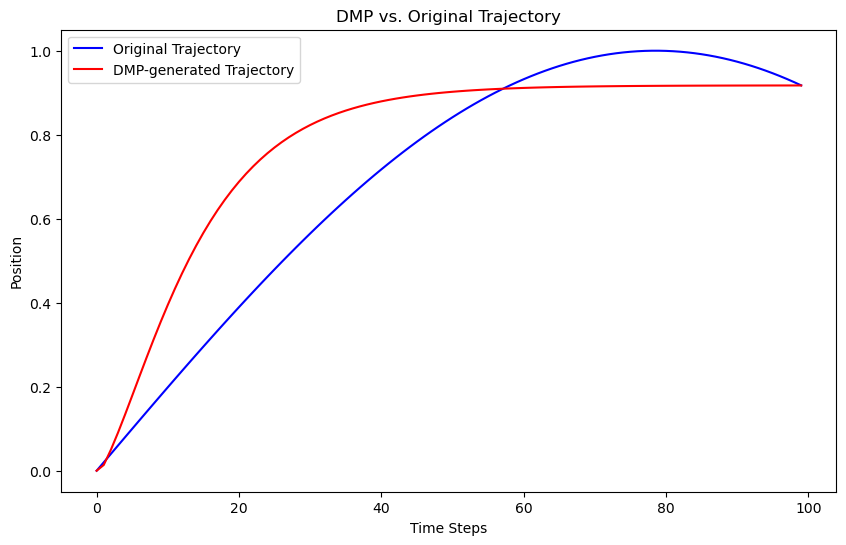

In [339]:
discrete_dmp = DiscreteDMP()

traj = np.sin(np.arange(0, 1, 0.01) * 2)

y0 = traj[0]
g = traj[-1]

weights = discrete_dmp.learn(traj)

traj_track = discrete_dmp.unroll(y0, g)

t = np.arange(0, len(traj), 1)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(t, traj, label='Original Trajectory', color='b')
plt.plot(t, traj_track, label='DMP-generated Trajectory', color='r')

plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.title('DMP vs. Original Trajectory')
plt.legend()

plt.show()


Discuss the results of your evaluation here.

YOUR ANSWER HERE

## (Optional) Rhythmic DMPs

Follow the description of DMPs with a rhythmic canonical system to write your own implementation that allows you to learn and reproduce rhythmic DMPs.

In [ ]:
class RhythmicDMP(object):
    def __init__(self):
        # YOUR CODE HERE
        raise NotImplementedError()

    def learn(self) -> None:
        """Learns a rhythmic dynamic motion primitive.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def unroll(self, y0: np.ndarray) -> np.ndarray:
        """Generates a rhythmic path that starts at y0, following a learned DMP shape.

        Keyword arguments:
        y0: np.ndarray -- Initial state of the system

        Returns a numpy array representing path waypoints.

        """
        # YOUR CODE HERE
        raise NotImplementedError()

Verify that your implementation is working correctly by experimenting with various rhythmic functions.

In [ ]:
### write code to test your implementation here

# YOUR CODE HERE
raise NotImplementedError()